# Install Dependencies

In [1]:
! pip install rdflib

In [2]:
# imports
import csv
import numpy as np
import os
import rdflib
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors as nn

# Load, check and save DDIS knowledge graph

In [3]:
# ONLY FOR GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ONLY FOR GOOGLE COLAB
os.chdir('drive/MyDrive/UZH/1. ATAI/Project')

In [12]:
!ls

autoencoder.h5	       ddis-movie-graph.tsv  KG.pickle		     wikidata
ddis-graph-embeddings  entities		     MIT_corpus
ddis-movie-graph.nt    entity_embeds_2d.npy  relation_embeds_2d.npy


In [5]:
# change to data directory
os.chdir('../data')

In [6]:
# define some prefixes
WD = rdflib.Namespace('http://www.wikidata.org/entity/')
WDT = rdflib.Namespace('http://www.wikidata.org/prop/direct/')
DDIS = rdflib.Namespace('http://ddis.ch/atai/')
RDFS = rdflib.namespace.RDFS
SCHEMA = rdflib.Namespace('http://schema.org/')

In [15]:
# load the graph from pickle
import pickle
with open('KG.pickle', 'rb') as f:
    graph = pickle.load(f)

In [105]:
# graph length
print('Number of triples: {}'.format(len(graph)))

Number of triples: 2056777


In [17]:
# load the embeddings
os.chdir('./ddis-graph-embeddings')
entity_emb = np.load('./entity_embeds.npy')
relation_emb = np.load('./relation_embeds.npy')
entity_file = './entity_ids.del'
relation_file = './relation_ids.del'

In [18]:
# entity embeddings shape
print('Entity embeddings shape: {}'.format(entity_emb.shape))

Entity embeddings shape: (158901, 256)


In [19]:
# relation embeddings shape
print('Relation embeddings shape: {}'.format(relation_emb.shape))

Relation embeddings shape: (248, 256)


In [20]:
# load the dictionaries
with open(entity_file, 'r') as ifile:
    ent2id = {rdflib.term.URIRef(ent): int(idx) for idx, ent in csv.reader(ifile, delimiter='\t')}
    id2ent = {v: k for k, v in ent2id.items()}
with open(relation_file, 'r') as ifile:
    rel2id = {rdflib.term.URIRef(rel): int(idx) for idx, rel in csv.reader(ifile, delimiter='\t')}
    id2rel = {v: k for k, v in rel2id.items()}

In [21]:
ent2lbl = {ent: str(lbl) for ent, lbl in graph.subject_objects(RDFS.label)}
lbl2ent = {lbl: ent for ent, lbl in ent2lbl.items()}
rel2lbl = {rel: str(lbl) for rel, lbl in graph.subject_objects(RDFS.label)}

# Get distinct wikidata properties from graph

In [ ]:
graph_properties = graph.query('''
        PREFIX ns1: <http://www.wikidata.org/prop/direct/>
        SELECT DISTINCT ?p WHERE {
            ?s ?p ?o
            FILTER( STRSTARTS(str(?p), str(ns1:)) )
        }
        ''')

In [ ]:
len(graph_properties)

251

In [ ]:
graph_properties.serialize()

In [ ]:
import re

def expand_property_labels(graph_properties, wikidata_properties):
    data = []
    for row in graph_properties:
        property_uri = row.p
        if property_uri.startswith('http://www.wikidata.org/prop/direct/'):
            ent = re.sub("http://www.wikidata.org/prop/direct/", "http://www.wikidata.org/entity/", property_uri)
            entity_uri = ent.split('/')[-1]
            property_label = \
            wikidata_properties.loc[wikidata_properties['id'] == entity_uri, 'label'].values[0]
            property_alt_label = \
            wikidata_properties.loc[wikidata_properties['id'] == entity_uri, 'altLabel'].values[0]

            all_labels_text = property_label + ', '
            if property_alt_label:
                str(all_labels_text) + str(property_alt_label)

            all_labels = re.split(', | or ', all_labels_text)
            for label in all_labels:
                data.append([property_uri, label])

    return pd.DataFrame(data, columns=['Property', 'PropertyLabel'])

In [ ]:
os.chdir("./../../data/")

In [ ]:
!ls

autoencoder.h5	       ddis-movie-graph.nt   entity_embeds_2d.npy    wikidata
ddis-graph-embeddings  ddis-movie-graph.tsv  relation_embeds_2d.npy


In [ ]:
# pre-saved all the properties and their labels from wikidata
wikidata_properties = pd.read_csv('wikidata/properties.csv')
df = expand_property_labels(graph_properties, wikidata_properties)
df.to_csv("wikidata/graph_properties_expanded.csv", index=False)

# Get Entities of Graph (Movies, Actors)

In [ ]:
# movies as "instance of wd:Film".
movies_film = graph.query('''
        PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
        PREFIX wd: <http://www.wikidata.org/entity/> 
        SELECT ?movie ?lbl WHERE {
            ?movie wdt:P31 wd:Q11424 .
            ?movie rdfs:label ?lbl .
        }
        ''')

In [ ]:
len(movies_film)

24384

In [ ]:
# movies as "has an IMDb ID starting with tt".
movies_imdb = graph.query('''
        PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
        PREFIX wd: <http://www.wikidata.org/entity/> 
        SELECT DISTINCT ?movie ?lbl WHERE {
            ?movie rdfs:label ?lbl .
            ?movie wdt:P345 ?imdb .
            FILTER( STRSTARTS(?imdb, "tt"))
        }
        ''')

In [ ]:
# actors as "has wdt:occupation wd:actor".
actors = graph.query('''
        PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
        PREFIX wd: <http://www.wikidata.org/entity/> 
        SELECT ?actor ?lbl WHERE {
            ?actor rdfs:label ?lbl .
            ?actor wdt:P106 wd:Q33999 .
        }
        ''')

In [ ]:
len(actors)

55878

In [ ]:
# actors as "has an IMDb ID starting with nm".
# actors as "has wdt:occupation wd:actor".
actors_imdb = graph.query('''
        PREFIX wdt: <http://www.wikidata.org/prop/direct/> 
        PREFIX wd: <http://www.wikidata.org/entity/> 
        SELECT DISTINCT ?actor ?lbl WHERE {
            ?actor rdfs:label ?lbl .
            ?actor wdt:P345 ?imdb .
            FILTER( STRSTARTS(?imdb, "nm"))
        }
        ''')

# PCA to compress embeddings to lower dimensions

# Find knee for optimal components value

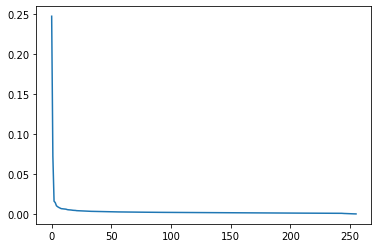

In [ ]:
# Eigenvalue cutoff to find best number for principal components
eig_vals, eig_vecs = np.linalg.eig(np.cov(entity_emb.T))
eig_vals = np.real(eig_vals)
eig_vecs = np.real(eig_vecs)
eig_vals = eig_vals / np.sum(eig_vals)
# sorted in descending order
eig_vals = np.sort(eig_vals)[::-1]

# plot the eigenvalues
import matplotlib.pyplot as plt
plt.plot(eig_vals)
plt.show()

In [ ]:
! pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# find knee value for optimal number of principal components
from kneed import KneeLocator
kl = KneeLocator(range(1, len(eig_vals)+1), eig_vals, curve='convex', direction='decreasing')
print('Knee value: {}'.format(kl.knee))

Knee value: 6


In [ ]:
# compress embeddings to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
entity_emb_2d = pca.fit_transform(entity_emb)
relation_emb_2d = pca.fit_transform(relation_emb)

In [ ]:
# reconstruct embeddings from 2D
entity_emb_rec = pca.inverse_transform(entity_emb_2d)
relation_emb_rec = pca.inverse_transform(relation_emb_2d)

In [ ]:
# compress embeddings to 1D
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
entity_emb_1d = pca.fit_transform(entity_emb)
relation_emb_1d = pca.fit_transform(relation_emb)

In [ ]:
# compress embeddings to 6D
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
entity_emb_6d = pca.fit_transform(entity_emb)
relation_emb_6d = pca.fit_transform(relation_emb)

In [ ]:
# compress embeddings to 50D
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
entity_emb_50d = pca.fit_transform(entity_emb)
relation_emb_50d = pca.fit_transform(relation_emb)

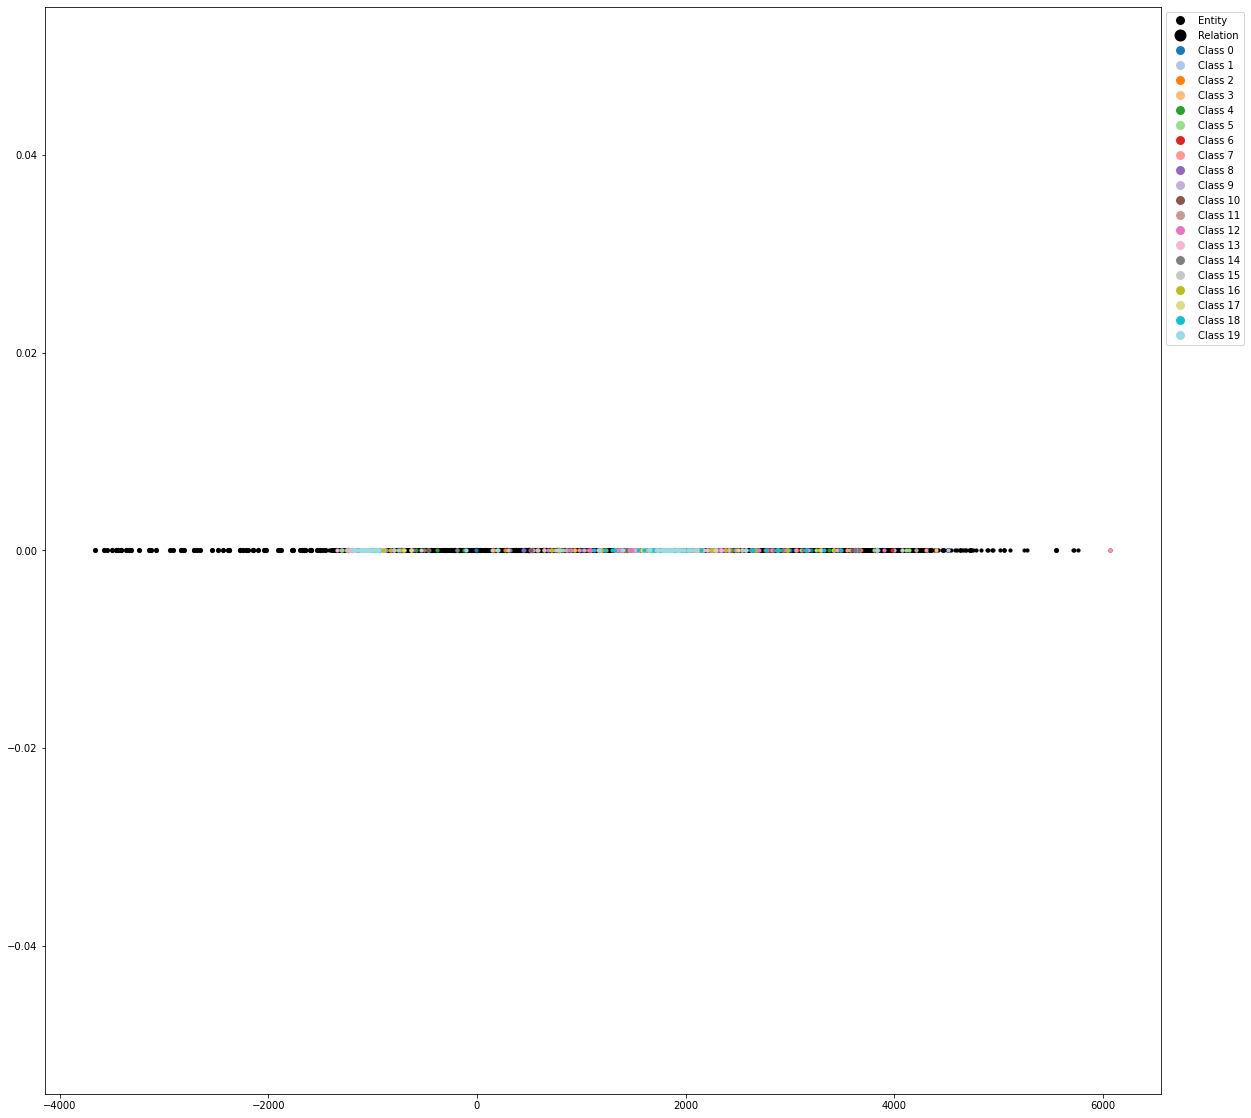

In [ ]:
# plot 1D embeddings
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(entity_emb_1d, np.zeros(len(entity_emb_1d)), c='k', s=10)
ax.scatter(relation_emb_1d, np.zeros(len(relation_emb_1d)), c='k', s=10, edgecolors='k', linewidths=2)
for i in range(20):
    ax.scatter(entity_emb_1d[i*100:(i+1)*100], np.zeros(100), c=colors[i], s=10)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
! ls

ddis-graph-embeddings  ddis-movie-graph.nt  ddis-movie-graph.tsv


In [ ]:
# save compressed embeddings to file
np.save('./entity_embeds_2d.npy', entity_emb_2d)
np.save('./relation_embeds_2d.npy', relation_emb_2d)

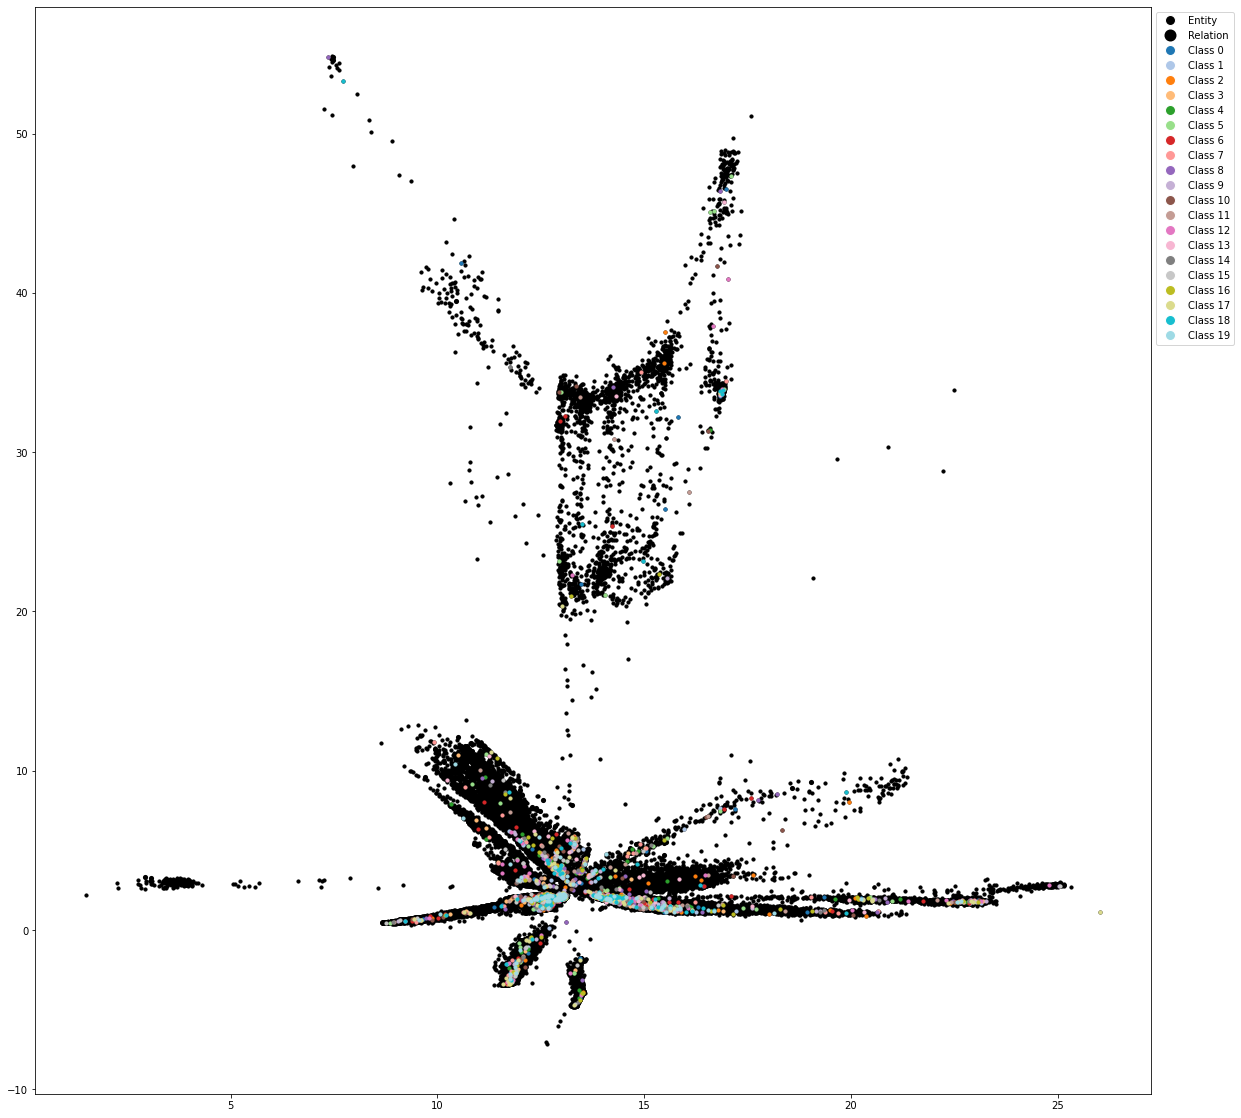

In [ ]:
# plot the embeddings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# define the colors
cmap = cm.get_cmap('tab20')
norm = colors.Normalize(vmin=0, vmax=19)
colors = [cmap(norm(i)) for i in range(20)]

# define the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Entity', markerfacecolor='k', markersize=10),
                     Line2D([0], [0], marker='o', color='w', label='Relation', markerfacecolor='k', markersize=10, markeredgewidth=2, markeredgecolor='k')]
for i in range(20):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Class {}'.format(i), markerfacecolor=colors[i], markersize=10))

# plot the embeddings
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(entity_emb_2d[:, 0], entity_emb_2d[:, 1], c='k', s=10)
ax.scatter(relation_emb_2d[:, 0], relation_emb_2d[:, 1], c='k', s=10, edgecolors='k', linewidths=2)
for i in range(20):
    ax.scatter(entity_emb_2d[i*100:(i+1)*100, 0], entity_emb_2d[i*100:(i+1)*100, 1], c=colors[i], s=10)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Autoencoder

## Shallow AE

In [ ]:
# use an autoencoder to compress embeddings to 2D
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# define the autoencoder
input_dim = entity_emb.shape[1]
encoding_dim = 2
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# train the autoencoder
autoencoder.fit(entity_emb, entity_emb, epochs=50, batch_size=256, shuffle=True, validation_split=0.20)

# get the encoder
encoder = Model(inputs=input_layer, outputs=encoder)

Epoch 1/50
497/497 [==============================] - 4s 5ms/step - loss: 70846.0312 - accuracy: 0.0011 - val_loss: 70400.7109 - val_accuracy: 9.7543e-04
Epoch 2/50
497/497 [==============================] - 3s 5ms/step - loss: 70753.9062 - accuracy: 7.6306e-04 - val_loss: 70320.1953 - val_accuracy: 9.1249e-04
Epoch 3/50
497/497 [==============================] - 2s 4ms/step - loss: 70667.7578 - accuracy: 8.4172e-04 - val_loss: 70242.9453 - val_accuracy: 7.5517e-04
Epoch 4/50
497/497 [==============================] - 2s 5ms/step - loss: 70584.1172 - accuracy: 8.4959e-04 - val_loss: 70167.1328 - val_accuracy: 7.8663e-04
Epoch 5/50
497/497 [==============================] - 3s 5ms/step - loss: 70501.8125 - accuracy: 8.3386e-04 - val_loss: 70091.9297 - val_accuracy: 7.8663e-04
Epoch 6/50
497/497 [==============================] - 2s 4ms/step - loss: 70420.2031 - accuracy: 7.6306e-04 - val_loss: 70015.7734 - val_accuracy: 8.1810e-04
Epoch 7/50
497/497 [==============================] - 3s

In [ ]:
autoencoder.save('./autoencoder.h5')

In [ ]:
# compress embeddings to 2D
entity_emb_2d = encoder.predict(entity_emb)
relation_emb_2d = encoder.predict(relation_emb)

8/8 [==============================] - 0s 3ms/step


In [ ]:
np.save('./entity_embeds_2d.npy', entity_emb_2d)
np.save('./relation_embeds_2d.npy', relation_emb_2d)

In [ ]:
entity_emb_2d.shape

(158901, 1)

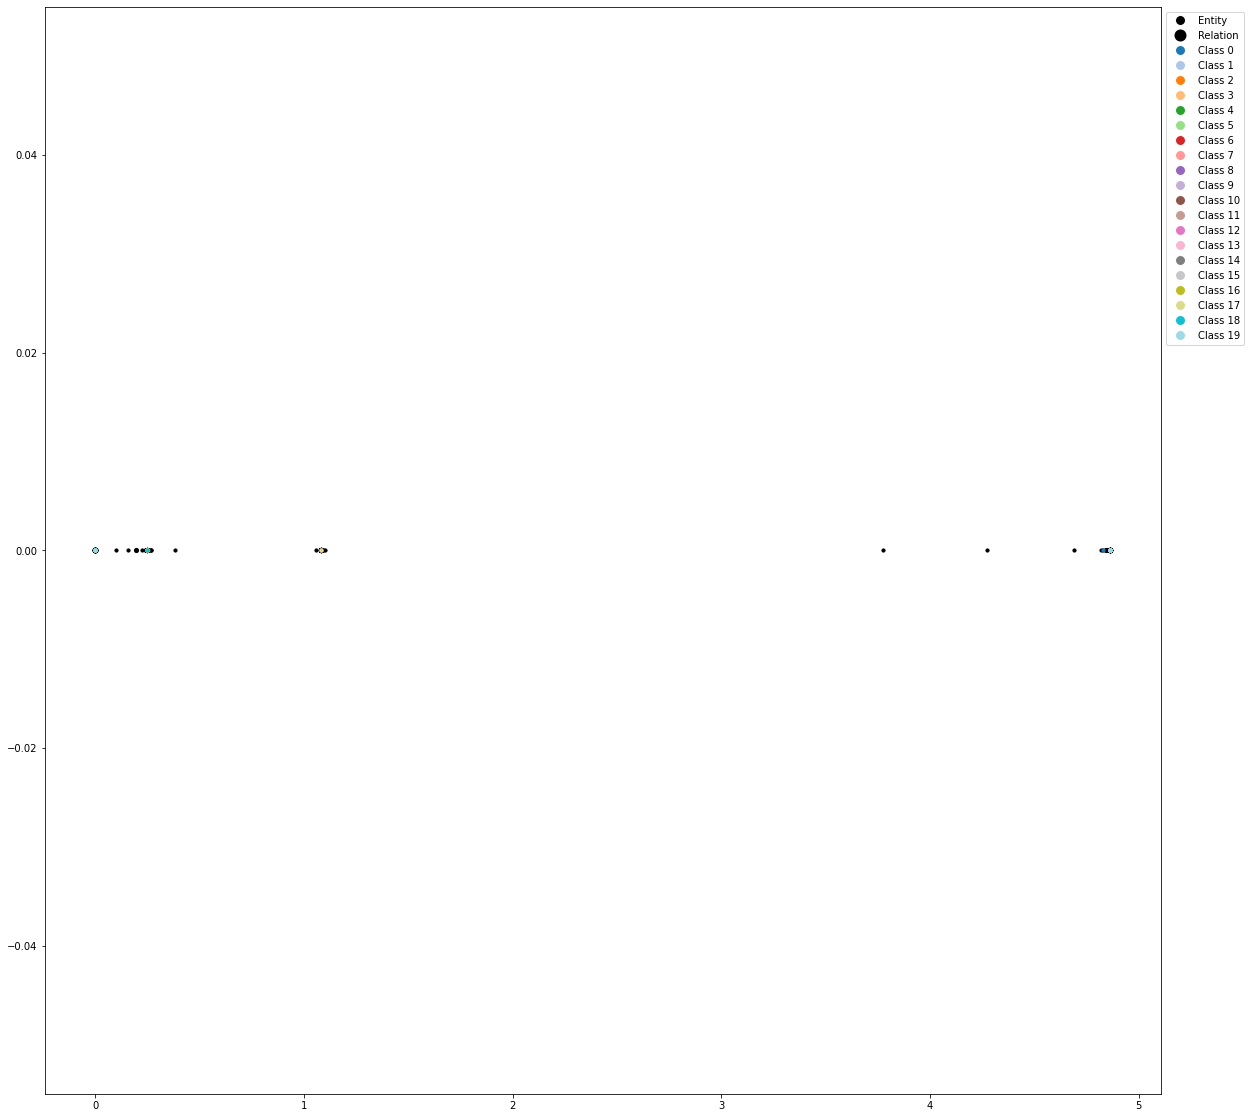

In [ ]:
# plot 1D embeddings
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(entity_emb_2d, np.zeros(len(entity_emb_2d)), c='k', s=10)
ax.scatter(relation_emb_2d, np.zeros(len(relation_emb_2d)), c='k', s=10, edgecolors='k', linewidths=2)
for i in range(20):
    ax.scatter(entity_emb_2d[i*100:(i+1)*100], np.zeros(100), c=colors[i], s=10)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

##

## Deep AE

In [ ]:
! pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=e341ef5462c3b974e8f4addd79bc6cb9c6fa9f98691f14845442165c12b666d9
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
# various
from math import ceil
from time import time
from tqdm import tqdm
import csv
import matplotlib.pylab as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import os
import PIL
# sklearn
import sklearn
import sklearn.utils
import sklearn.metrics
import sklearn.datasets
import sklearn.decomposition
# pytorch
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torchviz
# plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [ ]:
# setup a device; use CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [ ]:
# DeepAutoencoder architecture for compressing embeddings from 256D to 2D using a deep autoencoder on cuda device
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 32, bias=False),
            nn.Sigmoid(),
            nn.Linear(32, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, encoding_dim, bias=False),
        )
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(encoding_dim),
            nn.Linear(encoding_dim, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 32, bias=False),
            nn.Sigmoid(),
            nn.Linear(32, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, input_dim, bias=False),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
# initialize embeddings for DeepAutoencoder
entity_emb = torch.from_numpy(np.load('./entity_embeds.npy')).float().to(device)
relation_emb = torch.from_numpy(np.load('./relation_embeds.npy')).float().to(device)

In [ ]:
# initialize and train the autoencoder
n_epochs = 40_000 # set the number of training epochs
autoencoder = DeepAutoencoder(input_dim, encoding_dim)

# initialize the model
deep_ae = autoencoder.to(device)

# prepare the input
x = torch.Tensor(entity_emb).to(device)

# train for some epochs
optim = torch.optim.Adam(deep_ae.parameters(), lr=0.01)
deep_ae.train() # set to training mode
trace = []
for _ in tqdm(range(n_epochs)):
    # setup
    optim.zero_grad()
    
    # fetch reconstructed image
    pred = deep_ae(x)
    
    # apply MSE
    loss = F.mse_loss(pred, x)
    
    # gradient descent step
    loss.backward()
    optim.step()
    
    # record loss
    trace.append(loss.item())

# save the model
torch.save(deep_ae.state_dict(), './autoencoder.pth')

# set to testing mode for subsequent cells
_ = deep_ae.eval()

100%|██████████| 40000/40000 [13:01<00:00, 51.15it/s]


In [ ]:
# define the autoencoder
input_dim = entity_emb.shape[1]
encoding_dim = 2
autoencoder = DeepAutoencoder(input_dim, encoding_dim)

# move the autoencoder to cuda device
autoencoder = autoencoder.to(device)

# prepare the data
x = torch.Tensor(entity_emb).to(device)

# define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# set to training mode
autoencoder.train()

# train the autoencoder
num_epochs = 40
trace = []
# num_epochs = 0 # skip training if pre-trained model will be loaded later on
for _ in tqdm(range(num_epochs)):
    # ===================forward=====================
    output = autoencoder(x)
    loss = criterion(output, x)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # ===================log========================
    trace.append(loss.item())
    # print the loss
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

# save the autoencoder model
torch.save(autoencoder.state_dict(), './autoencoder.pth')

# set to testing mode for subsequent cells
_ = autoencoder.eval()

In [ ]:
# compress embeddings to 2D
entity_emb_2d = autoencoder.encoder(torch.from_numpy(entity_emb).float().to(device)).detach().cpu().numpy()
relation_emb_2d = autoencoder.encoder(torch.from_numpy(relation_emb).float().to(device)).detach().cpu().numpy()

# save compressed embeddings to file
np.save('./entity_embeds_2d.npy', entity_emb_2d)
np.save('./relation_embeds_2d.npy', relation_emb_2d)

In [ ]:
entity_emb_rec = autoencoder.decoder(torch.from_numpy(entity_emb_2d).float().to(device)).detach().cpu().numpy()
relation_emb_rec = autoencoder.decoder(torch.from_numpy(relation_emb_2d).float().to(device)).detach().cpu().numpy()

# Embeddings for TransE and RESCAL

# Query Graph for movies and similarities

In [ ]:
# Find the Wikidata ID for the movie (https://www.wikidata.org/wiki/Q132863 is the ID for "Top Gun: Maverick")
# Choose your own movie
movie = WD['Q31202708']

# Find the movie in the graph
movie_id = ent2id[movie]

# we compare the embedding of the query entity to all other entity embeddings
distances = pairwise_distances(entity_emb[movie_id].reshape(1, -1), entity_emb, metric='cosine').flatten()

# and sort them by distance
most_likely = np.argsort(distances)

# we print rank, entity ID, entity label, and distance
for rank, idx in enumerate(most_likely[:20]):
    rank = rank + 1
    ent =  id2ent[idx] # eg: http://www.wikidata.org/entity/Q31202708 
    q_id = ent.split('/')[-1] # to convert 'http://www.wikidata.org/entity/Q31202708' to 'Q31202708'
    lbl = ent2lbl[ent] # eg: 'Top Gun: Maverick'
    dist = distances[idx] # eg: 0.0

    print(f'{rank:2d}. {dist:.3f} {q_id:10s} {lbl}')

 1. 0.000 Q31202708  Top Gun: Maverick
 2. 0.205 Q39072454  Terminator: Dark Fate
 3. 0.223 Q590252    Jack Reacher
 4. 0.224 Q29261993  Mission: Impossible – Fallout
 5. 0.225 Q17548046  Mission: Impossible – Rogue Nation
 6. 0.228 Q110138    Top Gun
 7. 0.231 Q23759268  The Mummy
 8. 0.235 Q628154    Mission: Impossible – Ghost Protocol
 9. 0.235 Q25136669  Only the Brave
10. 0.237 Q29021224  Bad Boys for Life
11. 0.241 Q1466736   Pollock
12. 0.241 Q27188178  Aladdin
13. 0.242 Q367163    Lions for Lambs
14. 0.243 Q23707684  Mary Shelley
15. 0.243 Q74958     Blood Diamond
16. 0.244 Q22957393  Ant-Man and the Wasp
17. 0.244 Q105549458 Top Gun
18. 0.244 Q1226599   Dinner for Schmucks
19. 0.245 Q3286391   A Star Is Born
20. 0.246 Q20026847  Hell or High Water


In [ ]:
movie_emb = entity_emb[ent2id[movie]]

# Find the predicate (relation) of the genre (https://www.wikidata.org/wiki/Property:P136 is the ID for "genre")
genre = WDT['P136']
genre_emb = relation_emb[rel2id[genre]]

# combine according to the TransE scoring function
lhs = movie_emb + genre_emb

# compute distance to *any* entity
distances = pairwise_distances(lhs.reshape(1, -1), entity_emb).reshape(-1)

# find most plausible tails
most_likely = np.argsort(distances)

# show most likely entities
for rank, idx in enumerate(most_likely[:20]):
    rank = rank + 1
    ent = id2ent[idx] # eg: https://www.wikidata.org/wiki/Q31202708
    q_id = ent.split('/')[-1]
    lbl = ent2lbl[ent] # eg: 'comedy film'
    dist = distances[idx] # eg: 3000.0

    print(f'{rank:2d}. {dist:.3f} {q_id:10s} {lbl}')

 1. 3460.991 Q188473    action film
 2. 3498.822 Q130232    drama
 3. 3656.463 Q157443    comedy film
 4. 3691.237 Q2484376   thriller film
 5. 3727.178 Q319221    adventure film
 6. 3756.496 Q1054574   romance film
 7. 3775.909 Q859369    comedy-drama
 8. 3800.847 Q959790    crime film
 9. 3818.997 Q15898171  survival film
10. 3825.304 Q471839    science fiction film
11. 3832.802 Q157394    fantasy film
12. 3838.589 Q52207399  film based on a novel
13. 3856.502 Q2973181   speculative fiction film
14. 3873.949 Q2297927   spy film
15. 3885.653 Q645928    biographical film
16. 3894.263 Q185867    film noir
17. 3908.501 Q1535153   superhero film
18. 3917.187 Q11424     film
19. 3927.583 Q496523    heist film
20. 3934.951 Q191489    melodrama


In [ ]:
# Top Gun: Maverick entity embedding
head = entity_emb[ent2id[movie]]
# genre relation embedding
rel = relation_emb[rel2id[WDT.P136]]
# combine according to the TransE scoring function
tail = head + rel

# compute distance to *any* entity
distances = pairwise_distances(tail.reshape(1, -1), entity_emb).reshape(-1)

# find most plausible tails
most_likely = np.argsort(distances)

# show most likely entities
for rank, idx in enumerate(most_likely[:20]):
    rank = rank + 1
    ent = id2ent[idx] # eg: https://www.wikidata.org/wiki/Q31202708
    q_id = ent.split('/')[-1]
    lbl = ent2lbl[ent] # eg: 'comedy film'
    dist = distances[idx] # eg: 3000.0

pd.DataFrame({'distance': distances[most_likely[:20]], 'entity': most_likely[:20], 'label': [ent2lbl[id2ent[idx]] for idx in most_likely[:20]], 'rank': range(1, 21)})

,distance,entity,label,rank
0,3460.990967,128,action film,1
1,3498.822266,83,drama,2
2,3656.463135,1185,comedy film,3
3,3691.236572,45,thriller film,4
4,3727.178467,705,adventure film,5
5,3756.496094,799,romance film,6
6,3775.908691,2155,comedy-drama,7
7,3800.846680,4811,crime film,8
8,3818.996826,4526,survival film,9
9,3825.303955,586,science fiction film,10


# Find Errors

## Top Gun: Maverick

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# Check embedding for Top Gun: Maverick genre
genre = set(graph.query('''
    prefix wdt: <http://www.wikidata.org/prop/direct/>
    prefix wd: <http://www.wikidata.org/entity/>

    SELECT ?obj ?lbl WHERE { 
        ?ent rdfs:label "Top Gun: Maverick"@en . 
        ?ent wdt:P136 ?obj .
        ?obj rdfs:label ?lbl .
    }
    '''))
{ent[len(WD):]: str(lbl) for ent, lbl in genre}

{'Q188473': 'action film'}

In [ ]:
# Top Gun: Maverick entity embedding
head = entity_emb[ent2id[WD['Q31202708']]]
# genre relation embedding
rel = relation_emb[rel2id[WDT.P136]]
# combine according to the TransE scoring function
tail = head + rel

# compute distance to *any* entity
distances = pairwise_distances(tail.reshape(1, -1), entity_emb).reshape(-1)
#distances = euclidean_distances(tail.reshape(1, -1), entity_emb).reshape(-1)

# find most plausible tails
most_likely = np.argsort(distances)

# compute ranks
ranks = distances.argsort().argsort()

In [ ]:
# show scores for "Top Gun: Maverick" entity
ranks = distances.argsort().argsort()
pd.DataFrame([(str(lbl), distances[ent2id[ent]], ranks[ent2id[ent]]) for ent, lbl in genre], columns=['label', 'distance', 'rank'])

,label,distance,rank
0,action film,3460.990967,0


## Jean Van Hamme

In [ ]:
# Check embedding for Jean Van Hamme profession
professions = set(graph.query('''
    prefix wdt: <http://www.wikidata.org/prop/direct/>
    prefix wd: <http://www.wikidata.org/entity/>

    SELECT ?obj ?lbl WHERE { 
        ?ent rdfs:label "Jean Van Hamme"@en . 
        ?ent wdt:P106 ?obj .
        ?obj rdfs:label ?lbl .
    }
    '''))
{ent[len(WD):]: str(lbl) for ent, lbl in professions}

{'Q329737': 'butcher'}

In [ ]:
# Jean Van Hamme entity embedding
head = entity_emb[ent2id[WD['Q428160']]]
# genre relation embedding
rel = relation_emb[rel2id[WDT.P106]]
# combine according to the TransE scoring function
tail = head + rel

# compute distance to *any* entity
distances = pairwise_distances(tail.reshape(1, -1), entity_emb).reshape(-1)
#distances = euclidean_distances(tail.reshape(1, -1), entity_emb_2d).reshape(-1)

# find most plausible tails
most_likely = np.argsort(distances)

# compute ranks
ranks = distances.argsort().argsort()

In [ ]:
# show scores for "Jean Van Hamme" entity
pd.DataFrame([(str(lbl), distances[ent2id[ent]], ranks[ent2id[ent]]) for ent, lbl in professions], columns=['label', 'distance', 'rank'])

,label,distance,rank
0,butcher,5196.63623,86817


In [ ]:
# most likely entities
for rank, idx in enumerate(most_likely[:20]):
    rank = rank + 1
    ent = id2ent[idx] 
    q_id = ent.split('/')[-1]
    lbl = ent2lbl[ent]
    dist = distances[idx]

    print(f'{rank:2d}. {dist:.3f} {q_id:10s} {lbl}')

 1. 3223.151 Q36180     writer
 2. 3382.130 Q33999     actor
 3. 3397.583 Q6625963   novelist
 4. 3492.735 Q1930187   journalist
 5. 3549.961 Q4610556   model
 6. 3616.398 Q639669    musician
 7. 3628.231 Q67311526  Obalky knih.cz
 8. 3667.631 Q150       French
 9. 3694.667 Q1028181   painter
10. 3744.304 Q245068    comedian
11. 3763.197 Q33231     photographer
12. 3782.485 Q1053574   executive producer
13. 3804.955 Q2629392   puppeteer
14. 3866.757 Q727911    Largo Winch
15. 3872.162 Q2500638   creator
16. 3879.432 Q386854    drummer
17. 3903.312 Q43845     businessperson
18. 3907.720 Q1414443   filmmaker
19. 3909.215 Q706364    art director
20. 3916.239 Q21169216  actress


In [ ]:
# parent class
set(graph.objects(WD['Q428160'], WDT.P279))

set()

In [ ]:
# ddis:indirectSubclassOf next

# set the head entity to Top Gun:Maverick
head = entity_emb[ent2id[WD.Q31202708]]
# now we try to find the parent class
pred = relation_emb[rel2id[WDT.P31]]
# combine according to the TransE scoring function
lhs = head + pred
# compute distance to *any*u entity
dist = pairwise_distances(lhs.reshape(1, -1), entity_emb).reshape(-1)
# find most plausible tails
most_likely = dist.argsort()
# show most likely entities
pd.DataFrame([
    (id2ent[idx][len(WD):], ent2lbl[id2ent[idx]], dist[idx], rank+1)
    for rank, idx in enumerate(most_likely[:10])],
    columns=('Entity', 'Label', 'Score', 'Rank'))

,Entity,Label,Score,Rank
0,Q11424,film,3284.382568,1
1,Q31202708,Top Gun: Maverick,3805.377197,2
2,Q229390,3D film,3845.184570,3
3,Q506240,television film,3898.092041,4
4,Q24869,feature film,4028.055664,5
5,Q18011172,film project,4065.813477,6
6,Q5398426,television series,4070.265137,7
7,Q24862,short film,4084.750732,8
8,Q25110269,live-action/animated film,4184.317383,9
9,Q240862,director's cut,4189.645020,10


## General Case

In [ ]:
# SPARQL query to find instance of a given entity
def get_instances(entity):
    instance = set(graph.query(f'''
        prefix wdt: <http://www.wikidata.org/prop/direct/>
        prefix wd: <http://www.wikidata.org/entity/>

        SELECT ?obj ?lbl WHERE {{
            ?ent rdfs:label "{entity}"@en . 
            ?ent wdt:P31 ?obj .
            ?obj rdfs:label ?lbl 
        }}
        '''))
    return {ent[len(WD):]: str(lbl) for ent, lbl in instance}

In [ ]:
entity = "Top Gun: Maverick"
get_instances(entity)

{'Q11424': 'film'}

In [ ]:
# print first ten entities in ent2lbl
for i, (ent, lbl) in enumerate(ent2lbl.items()):
    print(f'{i:3d}. {ent[len(WD):]:10s} {lbl}')
    if i == 10:
        break

  0.            node description
  1. chema#label node label
  2. P1258      Rotten Tomatoes ID
  3. P161       cast member
  4. rect/P161  cast member
  5. P1651      YouTube video ID
  6. P1657      MPAA film rating
  7. rect/P1657 MPAA film rating
  8. P1712      Metacritic ID
  9. P1874      Netflix ID
 10. P1981      FSK film rating


In [ ]:
# loop through all entities (subject, object, predicate) in graph and add to set
# check whether entity is in ent2lbl, if not add to set
unknown_entities = set()
for s, p, o in graph:
    if s not in ent2lbl:
        unknown_entities.add(s)
    if p not in rel2lbl:
        unknown_entities.add(p)
    if o not in ent2lbl:
        unknown_entities.add(o)

In [ ]:
len(unknown_entities)

412687

In [ ]:
from rdflib.term import URIRef, Literal
entities = set(graph.subjects()) | {s for s in graph.objects() if isinstance(s, URIRef)}
predicates = set(graph.predicates())
literals = {s for s in graph.objects() if isinstance(s, Literal)}
with_type = set(graph.subjects(WDT['P31'], None))
with_super = set(graph.subjects(WDT['P279'], None))
types = set(graph.objects(None, WDT['P31']))
supers = set(graph.objects(None, WDT['P279']))
with_label = set(graph.subjects(RDFS.label, None))

n_ents = len(entities)
n_rels = len(predicates)
n_lits = len(literals)
t_tot = len(graph)
t_ent = len([1 for s,p,o in graph.triples((None, None, None)) if isinstance(o, URIRef)])
t_lit = t_tot - t_ent
n_notype = len(entities - with_type - with_super)
n_notype_flt = len(entities - with_type - with_super - types - supers)

pd.DataFrame([
    ('number of entities', f'{n_ents:n}'),
    ('number of literals', f'{n_lits:n}'),
    ('number of predicates', f'{n_rels:n}'),
    ('number of triples', f'{t_tot:n}'),
    ('number of ent-ent triples', f'{t_ent:n}'),
    ('number of ent-lit triples', f'{t_lit:n}'),
    ('number of entities w/o label', f'{len(entities - with_label):n}'),
    ('number of predicates w/o label', f'{len(predicates - with_label):n}'),
    ('number of entities w/o type', f'{n_notype:n}'),
    ('number of instances w/o type', f'{n_notype_flt:n}'),
    ])

,0,1
0,number of entities,159154
1,number of literals,411590
2,number of predicates,255
3,number of triples,2056777
4,number of ent-ent triples,1498899
5,number of ent-lit triples,557878
6,number of entities w/o label,1095
7,number of predicates w/o label,2
8,number of entities w/o type,5761
9,number of instances w/o type,344


In [ ]:
for e in list(entities - with_type - with_super)[:10]:
  print(ent2lbl[e])

television play
certificate
Olympic sport
honorary award
social integration
medical facility
Klingon
fictional military unit
steel bridge
city of raion surbodinance


In [ ]:
for e in list(entities - with_type - with_super - types - supers)[:10]:
  try:
    print(ent2lbl[e])
  except:
    pass

Rebibbia
industry
replaces
published in
MTRCB rating
depicted by
student of
screenwriter
instance of


In [ ]:
# print first ten subjects in the graph
for i, s in enumerate(graph.subjects()):
    e = ent2lbl.get(s, None)
    print(f'{i:3d}. {e}')
    if i == 10:
        break

  0. SVT Drama
  1. JFK
  2. Madame Bovary
  3. Columbia TriStar Television
  4. Catherine Ferran
  5. Christian Hetland Jepsen
  6. Bulletproof Monk
  7. Cherrybomb
  8. Tweetie Pie
  9. Doña Bárbara
 10. Things Are Tough All Over


# Load and Analyze Entities

In [22]:
# number of entities in the graph
triples = {(s, p, o) for s,p,o in graph.triples((None, None, None)) if isinstance(o, rdflib.term.URIRef)}
len({s for s,p,o in triples} | {o for s,p,o in triples})

158900

In [23]:
# dump triples to pickle file
import pickle
with open('triples.pickle', 'wb') as f:
    pickle.dump(triples, f)

In [26]:
predicates = {p for p in graph.predicates()}
len({p for p in predicates})

255

In [27]:
# dump triples to pickle file
with open('predicates.pickle', 'wb') as f:
    pickle.dump(predicates, f)

In [16]:
predicates[:10]

TypeError: ignored

In [ ]:
for s, p, o in [(s, p, o) for s, p, o in triples]:
    for i, t in enumerate([ent2lbl[s], rel2lbl[p], ent2lbl[o]]):
      print(f'{i:3d}. {t}')
      if i == 10:
          break

In [ ]:
from collections import defaultdict
from plotly.offline import iplot
import plotly.graph_objs as go
pdeg = defaultdict(int)
for s,p,o in graph.triples((None, None, None)):
    pdeg[p] += 1

iplot(dict(
    data=[go.Histogram(x=[cnt for cnt in pdeg.values() if cnt])],
    layout=go.Layout(
        title='Predicate distribution',
        xaxis=dict(
            title='Number of times the predicate is used'),
        yaxis=dict(
            title='Count'),
)))

In [ ]:
entities = [s for s in graph.subjects()]

In [ ]:
entities[:10]

[rdflib.term.URIRef('http://www.wikidata.org/entity/Q15837493'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q28726364'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q3301799'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q18914954'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q4967004'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q2033271'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q1810939'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q3107204'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q101209967'),
 rdflib.term.URIRef('http://www.wikidata.org/entity/Q774547')]

In [ ]:
# display the embeddings of the different types of entities in the graph as a scatter plot and highlight the entities in different colors
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from plotly.offline import iplot
import numpy as np

# ent2type: entity to type
ent2type = {ent: ent2lbl[ent] for ent in entities if ent in ent2lbl}

# get the embeddings of the entities in the graph
ent_embs = np.array([ent for ent in entity_emb])

# reduce the dimensionality of the embeddings to 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
ent_embs_2d = tsne.fit_transform(ent_embs)

# get the labels of the entities in the graph
ent_lbls = [ent2lbl[ent] for ent in entity_emb]

# get the types of the entities in the graph
ent_types = [ent2type[ent] for ent in entity_emb]

# get the unique types of the entities in the graph
unique_types = list(set(ent_types))

# create a dictionary that maps each type to a color
type2color = {t: f'rgb({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)})' for t in unique_types}

# create a dictionary that maps each type to a list of entities of that type
type2ents = {t: [] for t in unique_types}
for ent, t in zip(entity_emb, ent_types):
    type2ents[t].append(ent)

# create a dictionary that maps each type to a list of embeddings of entities of that type
type2embs = {t: [] for t in unique_types}
for emb, t in zip(ent_embs_2d, ent_types):
    type2embs[t].append(emb)

# create a dictionary that maps each type to a list of labels of entities of that type
type2lbls = {t: [] for t in unique_types}
for lbl, t in zip(ent_lbls, ent_types):
    type2lbls[t].append(lbl)


# create a list of scatter plots, one for each type
data = []
for t in unique_types:
    data.append(go.Scatter(
        x=[emb[0] for emb in type2embs[t]],
        y=[emb[1] for emb in type2embs[t]],
        mode='markers',
        name=t,
        marker=dict(
            size=10,
            color=type2color[t],
            line=dict(
                width=2,
                color='DarkSlateGrey'
            ),
            opacity=0.7
        ),
        text=type2lbls[t]
    ))

# create the layout of the scatter plot
layout = go.Layout(
    title='Entity embeddings',
    hovermode='closest',
    xaxis=dict(
        title='x',
        ticklen=5,
        zeroline=False,
        gridwidth=2
    ),
    yaxis=dict(
        title='y',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=True
)

# create the figure
fig = go.Figure(data=data, layout=layout)

# display the figure
iplot(fig)

In [ ]:
entity_emb[ent2id[WD.Q4359230]]

In [ ]:
import operator
top = list(sorted(pdeg.items(), key=operator.itemgetter(1),reverse=True))
pd.DataFrame([
    (
        category, # category
        ent2lbl[category], # category label
        relations  # relations
    )
    for category, relations in top if category in ent2lbl and relations > 1000],
    columns=('Category', 'Relations'))

,Category,Relations
0,cast member,288856
1,instance of,169427
2,node label,158059
3,node description,150006
4,IMDb ID,124038
...,...,...
96,religion,1193
97,mother,1122
98,participant in,1118
99,BBFC rating,1109


In [ ]:
entity = str('Shaft')
get_instances(entity)

In [ ]:
# get instances of known subjects and add subject, instance pair to dictionary
instances = {}
for s in known_subjects[:100]:
    try:
        instances[s] = get_instances(s)
    except:
        pass

In [ ]:
# print first ten instances
for i, (s, instance) in enumerate(instances.items()):
    print(f'{i:3d}. {s:20s} {instance}')
    if i == 100:
        break

In [ ]:
# function to compute the rank of a given entity
def rank_entity(head, pred, tail):
    lhs = head + pred
    dist = pairwise_distances(lhs.reshape(1, -1), entity_emb).reshape(-1)
    return dist.argsort().argsort()[tail] + 1

In [ ]:
head = entity_emb[ent2id[lbl2ent['Tiger Tanaka']]]
pred = relation_emb[rel2id[WDT.P106]]
rank_entity(head, pred, ent2id[WD.Q4359230])

84

In [ ]:
# set the head entity to Jean Van Hamme
head = entity_emb[ent2id[WD.Q428160]]
# now we try ddis:indirectSubclassOf
pred = relation_emb[rel2id[WDT.P31]]
rank_entity(head, pred, ent2id[WD.Q36180])

5

In [ ]:
from scipy.spatial import cKDTree
#matrix[cKDTree(matrix).query(search_vec, k=1)[1]]

In [ ]:
# fit a nearest neighbor model to the entity embeddings
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(entity_emb)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [ ]:
# get the nearest neighbors of the entity with id 0
neighbors = knn.kneighbors(entity_emb[0].reshape(1, -1), return_distance=False)
neighbors

array([[    0, 66965, 38120, 22539, 34713, 36856, 40938, 41108, 19538,
        42358]])

In [ ]:
# function to detect errors in knowledge graph triples
def detect_error_knn(subject, predicate, object):
    # entity embedding
    head = entity_emb[ent2id[subject]]
    # relation embedding
    rel = relation_emb[rel2id[predicate]]
    # combine according to the TransE scoring function
    tail = head + rel

    # compute distance to 10 closest entities (= neighbors)
    neighbors = knn.kneighbors(tail.reshape(1, -1), return_distance=False)

    # return s, p, o, if o not in neighbors, else None
    if ent2id[object] not in neighbors:
       return ent2lbl[subject], rel2lbl[predicate], ent2lbl[object]
    else:
       return None

In [ ]:
# function to detect errors in knowledge graph triples
def detect_error(subject, predicate, object):
    # entity embedding
    head = entity_emb[ent2id[subject]]
    # relation embedding
    rel = relation_emb[rel2id[predicate]]
    # combine according to the TransE scoring function
    tail = head + rel

    # compute distance to *any* entity
    distances = pairwise_distances(tail.reshape(1, -1), entity_emb).reshape(-1)

    # find most plausible tails
    most_likely = np.argsort(distances)

    # compute ranks
    ranks = distances.argsort().argsort()

    # return s, p, o, distance and rank if rank above 10, else None
    if ranks[ent2id[object]]+1 > 10:
       return ent2lbl[subject], rel2lbl[predicate], ent2lbl[object], distances[ent2id[object]], ranks[ent2id[object]]+1
    else:
       return None

In [ ]:
# function to detect errors in knowledge graph triples -- plus some additional information
def detect_error_plus(subject, predicate, object):
    # entity embedding
    head = entity_emb[ent2id[subject]]
    # relation embedding
    rel = relation_emb[rel2id[predicate]]
    # combine according to the TransE scoring function
    tail = head + rel

    # compute distance to *any* entity
    distances = pairwise_distances(tail.reshape(1, -1), entity_emb).reshape(-1)

    # find most plausible tails
    most_likely = np.argsort(distances)

    # compute ranks
    ranks = distances.argsort().argsort()

    # return s, p, o, distance and rank if rank above 10, else None
    if ranks[ent2id[object]]+1 > 10:
       return ent2lbl[subject], rel2lbl[predicate], ent2lbl[object], distances[ent2id[object]], ranks[ent2id[object]]+1, [ent2lbl[id2ent[ent]] for ent in most_likely[:3]]
    else:
       return None

## Triples list

In [28]:
triples_list = list(triples)

In [29]:
len(triples_list)

1498899

In [ ]:
# find errors in Knowledge Graph
# only append if not none
errors = []
for i, (s, p, o) in enumerate(triples_list[:100]):
    if i % 1000 == 0:
        print(i)
    try:
      error = detect_error_knn(s, p, o)
      if error is not None:
          errors.append(error)
    except:
      pass

0


In [ ]:
pd.DataFrame(([(subj,pred,obj) 
    for subj,pred,obj in errors]), 
    columns=('Subject', 'Predicate', 'Object'))

,Subject,Predicate,Object
0,National Society of Film Critics Award for Bes...,winner,John Cassavetes
1,How to Train Your Dragon,voice actor,America Ferrera
2,The Notebook,cast member,Joan Allen
3,Apollo 13,cast member,Todd Hallowell
4,The Wiz,cast member,Willie C. Carpenter
5,São Paulo,twinned administrative body,Budapest
6,The Imitation Game,main subject,Homosexuality in the United Kingdom
7,1900,cast member,Patrizia De Clara
8,Hangmen Also Die!,cast member,Steve Clemente
9,Born Romantic,cast member,Adrian Lester


## Errors for lower categories

In [ ]:
# find errors in first 100 triples
# only append if not none
errors = []
for i, (s, p, o) in enumerate(triples_list[:10000]):
    if i % 1000 == 0:
        print(i)
    #if p in [WDT.]:
    if pdeg[p] < 1000:
      try:
        error = detect_error_2D(s, p, o)
        if error is not None:
            errors.append(error)
      except:
        pass

In [ ]:
pd.DataFrame(([(subj,pred,obj,dis,ran) 
    for subj,pred,obj,dis,ran in errors]), 
    columns=('Subject', 'Predicate', 'Object', 'Distance', 'Rank'))

,Subject,Predicate,Object,Distance,Rank
0,Playboy Enterprises,location of formation,Chicago,1206.978149,6054
1,Sivaji Productions,industry,show business,1590.658691,20439
2,Twilight Sparkle,student of,Princess Celestia,1357.503784,35672
3,Brother Bear,depicts,Inuit,2110.061035,52295
4,Terminator Genisys,IMDA rating,PG13,4921.098633,117095
...,...,...,...,...,...
257,Titanus,location of formation,Naples,1556.603638,15562
258,United States of America,contains administrative territorial entity,Rhode Island,1258.692139,36153
259,Guadeloupe,continent,North America,811.370117,3768
260,M. Night Shyamalan,owner of,Blinding Edge Pictures,3555.733398,129892


## Errors for actors

In [130]:
pot_actors = {}
for i, (s, p, o) in enumerate(triples_list):
  if p in ent_predicate['actor']:
    pot_actors[s] = (s, p, o)

In [131]:
len(pot_actors)

30597

In [ ]:
pot_actors.keys()

In [132]:
# only append if not none
errors = []
for i, (s, p, o) in enumerate(triples_list):
    if i % 1000 == 0:
        print(i)
    if s in pot_actors.keys() and p in [WDT.P106]:
      if o != "actor":
      #if pdeg[p] < 1000:
        try:
          error = detect_error_plus(s, p, o)
          if error is not None:
              errors.append(error)
        except:
          pass

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [133]:
errors_pot_actors = pd.DataFrame(([(subj,pred,obj,dis,ran,sim) 
    for subj,pred,obj,dis,ran,sim in errors]), 
    columns=('Subject', 'Predicate', 'Object', 'Distance', 'Rank', 'Most Similar'))

In [134]:
errors_pot_actors

,Subject,Predicate,Object,Distance,Rank,Most Similar
0,Alfred Pennyworth,occupation,butler,3634.647949,13,"[writer, journalist, businessperson]"
1,Doomsday,occupation,destruction,4158.274902,14,"[superhero, assassin, adventurer]"
2,Rafiki,occupation,shaman,3883.668701,24,"[writer, actor, journalist]"
3,Hercule Poirot,occupation,detective,3721.460693,12,"[writer, journalist, novelist]"
4,Hemingway & Gellhorn,occupation,novelist,5007.470215,125,"[television film, film, Hemingway & Gellhorn]"
5,Eobard Thawne,occupation,impostor,3686.170410,11,"[writer, actor, model]"
6,Count Olaf,occupation,fugitive,3740.771973,17,"[actor, writer, model]"
7,Uli Kunkel,occupation,con artist,3688.080078,11,"[musician, writer, actor]"
8,Bane,occupation,bounty hunter,3832.450195,27,"[writer, actor, assassin]"
9,Rick Deckard,occupation,bounty hunter,4007.575928,29,"[actor, teacher, novelist]"


In [135]:
# save errors pot actors to csv
errors_pot_actors.to_csv('../entities/errors_pot_actors.csv')

# Errors for non-actors

In [90]:
not_actors = {}
for i, (s, p, o) in enumerate(triples_list):
  if p in [WDT.P106] and o != "actor":
    not_actors[s] = (s, p, o)

In [120]:
# find errors in first 100 triples
# only append if not none
errors = []
for i, (s, p, o) in enumerate(triples_list):
    if i % 1000 == 0:
        print(i)
    if s in not_actors.keys() and p in [WDT.P161]:
      if o != "actor":
      #if pdeg[p] < 1000:
        try:
          error = detect_error_plus(s, p, o)
          if error is not None:
              errors.append(error)
        except:
          pass

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [121]:
errors_non_actors = pd.DataFrame(([(subj,pred,obj,dis,ran,sim) 
    for subj,pred,obj,dis,ran,sim in errors]), 
    columns=('Subject', 'Predicate', 'Object', 'Distance', 'Rank', 'Most Similar'))

In [122]:
errors_non_actors

,Subject,Predicate,Object,Distance,Rank,Most Similar
0,Hemingway & Gellhorn,cast member,Rodrigo Santoro,2816.014648,11,"[Peter Coyote, Brooke Adams, Keone Young]"
1,Hemingway & Gellhorn,cast member,Michael Pritchard,3021.098389,108,"[Peter Coyote, Brooke Adams, Keone Young]"
2,Hemingway & Gellhorn,cast member,Parker Posey,2939.032715,31,"[Peter Coyote, Brooke Adams, Keone Young]"
3,Hemingway & Gellhorn,cast member,Ivonne Coll,2986.566406,53,"[Peter Coyote, Brooke Adams, Keone Young]"
4,Hemingway & Gellhorn,cast member,William Hall,2874.390381,15,"[Peter Coyote, Brooke Adams, Keone Young]"
5,Hemingway & Gellhorn,cast member,Robert Duvall,2939.680420,32,"[Peter Coyote, Brooke Adams, Keone Young]"
6,Gregory Bastien,cast member,Bad Boys II,7248.929688,106145,"[Gregory Bastien, Smith Cho, Joe Pantoliano]"
7,Hemingway & Gellhorn,cast member,David Strathairn,2914.452393,23,"[Peter Coyote, Brooke Adams, Keone Young]"
8,Hemingway & Gellhorn,cast member,Nicole Kidman,3013.971680,91,"[Peter Coyote, Brooke Adams, Keone Young]"
9,Misha Arobelidze,cast member,247°F,7126.597656,105212,"[Misha Arobelidze, Scout Taylor-Compton, Micha..."


In [ ]:
# save errors non-actors to csv
errors_non_actors.to_csv("../entities/errors_non_actors.csv")

In [ ]:
# find errors in knowledge graph for triples related to movies
# only append if not none
errors = []
for i, (s, p, o) in enumerate(triples_list[:1000]):
    if i % 1000 == 0:
        print(i)
    if p in [WDT.P161, WDT.P31, WDT.P279, WDT.P361, WDT.P527]:
      try:
        error = detect_error(s, p, o)
        if error is not None:
            errors.append(error)
      except:
        pass

0


In [ ]:
pd.DataFrame(([(subj,pred,obj,dis,ran) 
    for subj,pred,obj,dis,ran in errors]), 
    columns=('Subject', 'Predicate', 'Object', 'Distance', 'Rank'))

,Subject,Predicate,Object,Distance,Rank
0,"Brutti, sporchi e cattivi",cast member,Linda Moretti,2791.644775,12
1,Ustanička ulica,cast member,Miodrag Krstović,3143.123535,118
2,Charlie Wilson's War,cast member,Ken Stott,2798.766357,18
3,Platoon,cast member,Kevin Dillon,2913.641357,17
4,"It's Your Turn, Laura Cadieux",cast member,Mireille Thibault,2833.557129,13
...,...,...,...,...,...
93,The Artist,cast member,Nina Siemaszko,3051.124756,108
94,Camila,cast member,Héctor Alterio,2791.545166,27
95,The Serpent,cast member,Minna Haapkylä,2932.135742,14
96,Selma,cast member,André Holland,2956.974121,32


## Attempt at all errors for KG (relevant to movies)

In [123]:
ent_type = {
    'title': [WD.Q11424, WD.Q24856, WD.Q5398426, WD.Q7725310, WD.Q15416],
    'director': [WD.Q2526255, WD.Q3455803],
    'character': [WD.Q95074, WD.Q15773347, WD.Q15632617],
    'actor': [WD.Q33999, WD.Q10800557],
    'genre': [WD.Q483394]
}

ent_predicate = {
    'director': [WDT.P57],
    'character': [WDT.P1441, WDT.P674],
    'actor': [WDT.P161, WDT.P175],
    'genre': [WDT.P136]
}

In [124]:
movies = pd.read_csv("../entities/graph_movies.csv")

In [136]:
# potential directors
pot_directors = {}
for i, (s, p, o) in enumerate(triples_list):
  if p in ent_predicate['director']:
    pot_directors[o] = (s, p, o)

# not directors
not_directors = {}
for i, (s, p, o) in enumerate(triples_list):
  if p in [WDT.P106] and o != "director":
    pot_directors[o] = (s, p, o)

# # potential actors
# pot_actors = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if p in ent_predicate['actor']:
#     pot_actors[s] = (s, p, o)

# # not actors
# not_actors = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if p in [WDT.P106] and o != "actor":
#     not_actors[s] = (s, p, o)

# # potential movie title
# pot_movie_title = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if s in movies['EntityLabel']:
#     pot_movie_title[s] = (s, p, o)

# # not movie title
# not_movie_title = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if p in [WDT.P31] and o not in ent_type['title']:
#     not_movie_title[s] = (s, p, o)

# # potential character
# pot_character = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if p in ent_predicate['character']:
#     pot_character[s] = (s, p, o)

# # not character
# not_character = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if p in [WDT.P31] and o != "character":
#     not_character[s] = (s, p, o)

# # potential genre
# pot_genre = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if p in ent_predicate['genre']:
#     pot_genre[s] = (s, p, o)

# # not genre
# not_genre = {}
# for i, (s, p, o) in enumerate(triples_list):
#   if p in [WDT.P31] and o not in ent_type['genre']:
#     not_genre[s] = (s, p, o)

In [149]:
# find errors in first 100 triples
# only append if not none
pot_errors = []
for i, (s, p, o) in enumerate(triples_list):
    if i % 1000 == 0:
        print(i)
    # potential directors
    if s in pot_directors.keys() and p in [WDT.P106]:
      if o != "director":
        pot_errors.append((s, p, o))
    # not directors
    if s in not_directors.keys() and p in [WDT.P57]:
      if o != "director":
        pot_errors.append((s, p, o))
    # # potential actors
    # if s in pot_actors.keys() and p in [WDT.P106]:
    #   if o != "actor":
    #     pot_errors.append((s, p, o))
    # # not actors
    # if s in not_actors.keys() and p in [WDT.P161]:
    #   if o != "actor":
    #     pot_errors.append((s, p, o))
    # # potential movie title
    # if s in pot_movie_title.keys() and p in [WDT.P31]:
    #   if o == "title":
    #     pot_errors.append((s, p, o))
    # # not movie title
    # if s in not_movie_title.keys() and p in [WDT.P31]:
    #   if o != "title":
    #     pot_errors.append((s, p, o))
    # potential character
    # if s in pot_character.keys() and p in [WDT.P31]:
    #   if o not in ent_type['character']:
    #     pot_errors.append((s, p, o))
    # # not character
    # if s in not_character.keys() and p in [WDT.P31]:
    #   if o not in ent_type['character']:
    #     pot_errors.append((s, p, o))
    # # potential genre
    # if s in pot_genre.keys() and p in [WDT.P31]:
    #   if o == "genre":
    #     pot_errors.append((s, p, o))
    # # not genre
    # if s in not_genre.keys() and p in [WDT.P136]:
    #   if o != "genre":
    #     pot_errors.append((s, p, o))       

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [150]:
len(pot_errors)

5223

In [151]:
errors = []
for s, p, o in pot_errors:
  try:
    error = detect_error_plus(s, p, o)
    if error is not None:
        errors.append(error)
  except:
    pass

In [152]:
detected_errors = pd.DataFrame(([(subj,pred,obj,dis,ran,sim) 
    for subj,pred,obj,dis,ran,sim in errors]), 
    columns=('Subject', 'Predicate', 'Object', 'Distance', 'Rank', 'Most Similar'))

In [153]:
detected_errors

,Subject,Predicate,Object,Distance,Rank,Most Similar
0,André Heller,occupation,showman,3553.908447,15,"[writer, musician, actor]"
1,Prince,occupation,acting,3845.387695,22,"[musician, actor, writer]"
2,Jacques Demy,occupation,dialogue writer,3698.637207,11,"[actor, writer, journalist]"
3,Dennis Hopper,occupation,sculptor,3432.838867,12,"[writer, actor, photographer]"
4,Yoko Ono,occupation,sculptor,3576.366455,13,"[musician, painter, photographer]"
5,Larry Clark,occupation,artist,3666.391846,13,"[writer, actor, filmmaker]"
6,André Heller,occupation,sculptor,3531.536133,13,"[writer, musician, actor]"


In [154]:
# save detected errors to csv
detected_errors.to_csv("../entities/director_errors.csv", index=False)

In [ ]:
errors = []
for s, p, o in pot_errors:
  try:
    error = detect_error(s, p, o)
    if error is not None:
        errors.append(error)
  except:
    pass

In [ ]:
pd.DataFrame(([(subj,pred,obj,dis,ran) 
    for subj,pred,obj,dis,ran in errors]), 
    columns=('Subject', 'Predicate', 'Object', 'Distance', 'Rank'))

,Subject,Predicate,Object,Distance,Rank
0,Hemingway & Gellhorn,occupation,novelist,5007.470215,125
1,Jacques Demy,occupation,dialogue writer,3698.637207,11
2,King Kong,occupation,actor,4148.906250,27
3,Larry Clark,occupation,artist,3666.391846,13
4,André Heller,occupation,showman,3553.908447,15
5,Yoko Ono,occupation,sculptor,3576.366455,13
6,Prince,occupation,acting,3845.387695,22
7,Dennis Hopper,occupation,sculptor,3432.838867,12
8,André Heller,occupation,sculptor,3531.536133,13


In [ ]:
# find errors in knowledge graph for triples related to movies
# only append if not none
errors = []
for i, (s, p, o) in enumerate(triples_list):
    if i % 1000 == 0:
        print(i)
    if p in WDT.P57:
      try:
        error = detect_error(s, p, o)
        if error is not None:
            errors.append(error)
      except:
        pass

In [ ]:
pd.DataFrame(([(subj,pred,obj,dis,ran) 
    for subj,pred,obj,dis,ran in errors]), 
    columns=('Subject', 'Predicate', 'Object', 'Distance', 'Rank'))

,Subject,Predicate,Object,Distance,Rank
0,Five,director,Penelope Spheeris,2999.323486,14
1,Revolution,director,Hugh Hudson,3059.424316,18
2,Shadow of the Thin Man,director,W. S. Van Dyke,2978.151367,16
3,The Grand Seduction,director,Don McKellar,2803.920898,19
4,Cinderella,director,Wilfred Jackson,2901.183838,14
...,...,...,...,...,...
2131,All I Want for Christmas,director,Fred Olen Ray,3073.601807,12
2132,The Longest Yard,director,Robert Aldrich,3125.302002,45
2133,Pixel Perfect,director,Mark A.Z. Dippé,2924.690430,34
2134,Grassroots,director,Stephen Gyllenhaal,3253.432373,32


In [ ]:
# set the head entity to film
head = entity_emb[ent2id[WD.Q2526255]]
# has property
pred = relation_emb[rel2idx['http://ddis.ch/atai/indirectSubclassOf']]
# combine according to the TransE scoring function
lhs = head + pred
# compute distance to *any* entity
dist = pairwise_distances(lhs.reshape(1, -1), entity_emb).reshape(-1)
# find most plausible tails
most_likely = dist.argsort()
# show most likely entities
pd.DataFrame([
    (id2ent[idx][len(WD):], ent2lbl[id2ent[idx]], dist[idx], rank+1)
    for rank, idx in enumerate(most_likely[:10])],
    columns=('Entity', 'Label', 'Score', 'Rank'))

In [ ]:
# find all "has property" entries for film (WD.Q11424)
cat = []
for s, p, o in graph.triples((WD.Q11424, None, None)):
    cat.append((s, p, o))

In [ ]:
for s, p, o in cat:
  try:
    print(ent2lbl[o])
  except: pass

moving image
series
audiovisual work
visual artwork
cinema
trailer


In [ ]:
for s, p, o in cat:
  try:
    print(ent2lbl[s])
  except: pass

In [ ]:
predicates = list(predicates)
for p in predicates:
  try:
    print(rel2lbl[p])
  except:
    pass

twinned administrative body
diplomatic relation
member of
after a work by
production company
contributor to the creative work or subject
performer
IMDA rating
operator
executive producer
creator
edition or translation of
place of burial
derivative work
copyright holder
plot expanded in
occupant
affiliation
choreographer
located in or next to body of water
work location
references work, tradition or theory
cast member
product or material produced
residence
season
participant in
film crew member
business model
narrative location
original broadcaster
make-up artist
presenter
EIRIN film rating
copyright license
member of the crew of
fabrication method
has works in the collection
noble title
node label
partially coincident with
health specialty
facet of
military branch
sex or gender
interested in
country of citizenship
takes place in fictional universe
place of death
mother
follows
historic county
copyright representative
JMK film rating
art director
languages spoken, written or signed
part

# Retrieve Categories

In [ ]:
unk_parents = list()
for o in graph.objects():
  if set(graph.objects(o, WDT.P279)) == set():
    unk_parents.append(o)

In [ ]:
len(unk_parents)

1673784

In [ ]:
unk_parents[:100]

In [ ]:
set(graph.objects(WD.Q1326354, WDT.P279))

{rdflib.term.URIRef('http://www.wikidata.org/entity/Q9332')}

In [ ]:
ent2lbl[WD.Q469201]

'Carlo Croccolo'

In [ ]:
set(graph.objects(WD.Q30, WDT.P279))

set()

In [ ]:
# Let's see if we can recover this from embeddings...

# set the head entity to bridge
head = entity_emb[ent2id[WD.Q165]]
# let's try with wdt:P279 (subClassOf) first
pred = relation_emb[rel2id[WDT.P279]]
# combine according to the TransE scoring function
lhs = head + pred
# compute distance to *any* entity
dist = pairwise_distances(lhs.reshape(1, -1), entity_emb).reshape(-1)
# find most plausible tails
most_likely = dist.argsort()
# show most likely entities
pd.DataFrame([
    (id2ent[idx][len(WD):], ent2lbl[id2ent[idx]], dist[idx], rank+1)
    for rank, idx in enumerate(most_likely[:10])],
    columns=('Entity', 'Label', 'Score', 'Rank'))

,Entity,Label,Score,Rank
0,Q165,sea,3145.157227,1
1,Q1336920,community college,5147.217285,2
2,Q1048835,political territorial entity,5198.593262,3
3,Q56061,administrative territorial entity,5290.255859,4
4,Q91325574,Trappist monastery,5301.979004,5
5,Q47488809,country for sports,5310.469238,6
6,Q133156,colony,5342.594238,7
7,Q205961,skill,5355.787109,8
8,Q10564300,copper mine,5364.628418,9
9,Q1973404,inland sea,5372.428223,10


In [ ]:
from pprint import pprint as pp
from rdflib.term import Literal
# get the 'sea' entity (wd:Q165)
sea = list(graph.subjects(None, Literal('sea', lang='en')))[0] # http://www.wikidata.org/entity/Q165

In [ ]:
# show inbound edges to wd:Q165
# some entities have 'sea' as its type (wdt:P31)
pp(list(graph.subject_predicates(sea)))

[(rdflib.term.URIRef('http://www.wikidata.org/entity/Q11540639'),
  rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P31'))]


In [ ]:
# show outbound edges from wd:Q165
# 'sea' has a description, image, and label but no parent type
pp(list(graph.predicate_objects(sea)))

[(rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'),
  rdflib.term.Literal('fictional military unit', lang='en')),
 (rdflib.term.URIRef('http://schema.org/description'),
  rdflib.term.Literal('military unit that exists only in fiction', lang='en'))]


In [ ]:
# load id/name mappings
rel2idx = {ent: int(idx) for idx, ent in csv.reader(open('relation_ids.del'), delimiter='\t')}
ent2idx = {ent: int(idx) for idx, ent in csv.reader(open('entity_ids.del'), delimiter='\t')}
idx2ent = {idx: ent for ent, idx in ent2idx.items()}

In [ ]:
# find triples (sea, ddis:indirectSubclassOf, ?)
# note that the ddis:indirectSubclassOf does not exist in the graph!
head = entity_emb[ent2id[WD.Q469201]]
pred = relation_emb[rel2idx['http://ddis.ch/atai/indirectSubclassOf']]
lhs = head + pred
dist = pairwise_distances(lhs.reshape(1, -1), entity_emb).reshape(-1)
most_likely = dist.argsort()

# show 10 most likely tails
pd.DataFrame([
    (id2ent[idx][len(WD):], ent2lbl[id2ent[idx]], dist[idx], rank+1)
    for rank, idx in enumerate(most_likely[:10])],
    columns=('Entity', 'Label', 'Score', 'Rank'))



#for i in dist.argsort()[:10]:
 # print(idx2ent[i])

,Entity,Label,Score,Rank
0,Q469201,Carlo Croccolo,4617.544922,1
1,Q121229,Roberto Risso,5014.926758,2
2,Q461477,Isa Miranda,5042.855469,3
3,Q60953,Lilli Palmer,5047.084473,4
4,Q1042185,Antonio Catania,5065.091309,5
5,Q3767179,Giovanni Esposito,5070.260742,6
6,Q535012,Frances Bergen,5085.470703,7
7,Q3762973,Giancarlo Siani,5085.948242,8
8,Q84592434,Emmanuel de Chauvigny,5092.514160,9
9,Q16949762,Azamat Bagatov,5093.382324,10


In [ ]:
supers = set(graph.objects(None, WDT['P279']))

In [ ]:
objects = set(graph.objects()) | {o for o in graph.objects() if isinstance(s, rdflib.term.URIRef)}

In [ ]:
no_super = objects - supers

In [ ]:
len(no_super)

545342

# Entity Similarity

In [ ]:
# which entities are similar to a given entity
ent = ent2id[WD.Q102225]
# we compare the embedding of the query entity to all other entity embeddings
dist = pairwise_distances(entity_emb[ent].reshape(1, -1), entity_emb).reshape(-1)
# order by plausibility
most_likely = dist.argsort()

pd.DataFrame([
    (
        id2ent[idx][len(WD):], # qid
        ent2lbl[id2ent[idx]],  # label
        dist[idx],             # score
        rank+1,                # rank
    )
    for rank, idx in enumerate(most_likely[:15])],
    columns=('Entity', 'Label', 'Score', 'Rank'))

,Entity,Label,Score,Rank
0,Q102225,Harry Potter and the Goblet of Fire,0.000000,1
1,Q102235,Harry Potter and the Order of the Phoenix,1839.364746,2
2,Q161678,Harry Potter and the Deathly Hallows – Part 1,1864.835327,3
3,Q161687,Harry Potter and the Half-Blood Prince,1895.976562,4
4,Q232009,Harry Potter and the Deathly Hallows – Part 2,1941.686646,5
5,Q102244,Harry Potter and the Chamber of Secrets,2000.969482,6
6,Q102438,Harry Potter and the Philosopher's Stone,2059.114502,7
7,Q102448,Harry Potter and the Prisoner of Azkaban,2140.694092,8
8,Q18199330,Fantastic Beasts and Where to Find Them,2350.040771,9
9,Q1880543,Harry Potter and the Deathly Hallows,2419.553467,10


In [ ]:
def similar_entities(entity):
  # which entities are similar to a given entity
  ent = ent2id[entity]
  # we compare the embedding of the query entity to all other entity embeddings
  dist = pairwise_distances(entity_emb[ent].reshape(1, -1), entity_emb).reshape(-1)
  # order by plausibility
  most_likely = dist.argsort()

  if dist[most_likely[1]] < 1000:
    print(ent2lbl[entity], dist[most_likely[1]], ent2lbl[id2ent[most_likely[1]]])

In [ ]:
subjects = list()
for s in graph.subjects():
  subjects.append(s)

In [ ]:
len(subjects)

2056777

In [ ]:
for e in subjects[:100]:
  try:
    similar_entities(e)
  except:
    pass